# Image Segmantation for Pothole Detection
(we know this would be very helpful in Romania expecially)

Let's import the dataset:

In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/pothole-image-segmentation-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Tudor\.cache\kagglehub\datasets\farzadnekouei\pothole-image-segmentation-dataset\versions\2


In [53]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

Define basic block of U-Net

In [35]:
class downConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class upConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, in_c // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_c // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_c // 2, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

Define U-Net

In [36]:
class unet_encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = downConv(in_c=3, out_c=64)
        self.block2 = downConv(in_c=64, out_c=128)
        self.block3 = downConv(in_c=128, out_c=256)
        self.block4 = downConv(in_c=256, out_c=512)
        self.block5 = downConv(in_c=512, out_c=1024)
        
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.block1(x)
        print(x1.shape)
        x2 = self.block2(self.pool(x1))
        print(x2.shape)
        x3 = self.block3(self.pool(x2))
        print(x3.shape)
        x4 = self.block4(self.pool(x3))
        print(x4.shape)
        x5 = self.block5(self.pool(x4))
        print(x5.shape)

        return [x1, x2, x3, x4, x5]
    
class unet_decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2,)
        self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2,)
        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2,)
        self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2,)
        
        self.block1 = upConv(in_c=1024, out_c=512)
        self.block2 = upConv(in_c=512, out_c=256)
        self.block3 = upConv(in_c=256, out_c=128)
        self.block4 = upConv(in_c=128, out_c=64)

    def forward(self, x_set):
        x1_1, x1_2, x1_3, x1_4, x1_5 = x_set
        
        x2_1 = self.upconv1(x1_5)
        x1_4 = x1_4[:, :, :x2_1.shape[2], :x2_1.shape[3]]
        
        x2_1 = torch.cat([x2_1, x1_4], dim=1)
        x2_1 = self.block1(x2_1)
        print(x2_1.shape)
        
        x2_2 = self.upconv2(x2_1)
        x1_3 = x1_3[:, :, :x2_2.shape[2], :x2_2.shape[3]]
        
        x2_2 = torch.cat([x2_2, x1_3], dim=1)
        x2_2 = self.block2(x2_2)
        print(x2_2.shape)

        x2_3 = self.upconv3(x2_2)
        x1_2 = x1_2[:, :, :x2_3.shape[2], :x2_3.shape[3]]
        
        x2_3 = torch.cat([x2_3, x1_2], dim=1)
        x2_3 = self.block3(x2_3)
        print(x2_3.shape)

        x2_4 = self.upconv4(x2_3)
        x1_1 = x1_1[:, :, :x2_4.shape[2], :x2_4.shape[3]]
        
        x2_4 = torch.cat([x2_4, x1_1], dim=1)
        x2_4 = self.block4(x2_4)
        print(x2_4.shape)
        
        return x2_4

In [37]:
class u_net(nn.Module):
    def __init__(self):
        super().__init__()

        self.part1 = unet_encoder()
        self.part2 = unet_decoder()

        self.seg_head = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.part1(x)
        x2 = self.part2(x1)

        x = self.seg_head(x2)

        return x

### Setup a Dataset and a DataLoader

In [73]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class YoloSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_size=(640, 640), transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(image_name)[0] + ".txt")

        # Load image as PIL Image
        image = Image.open(img_path).convert("RGB")

        # Get original width, height for mask scaling
        w, h = image.size

        mask = np.zeros((h, w), dtype=np.uint8)
        if os.path.exists(label_path):
            with open(label_path, "r") as file:
                for line in file:
                    parts = list(map(float, line.strip().split()))
                    cls, coords = parts[0], parts[1:]
                    points = np.array(coords).reshape(-1, 2)
                    points[:, 0] *= w
                    points[:, 1] *= h
                    points = points.astype(np.int32)
                    cv2.fillPoly(mask, [points], color=1)

        # Resize mask with cv2 (to 256x256, same as transform.Resize)
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

        # Apply transforms on PIL image (Resize + ToTensor + Normalize)
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [74]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to [0, 1] range
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for U-Net
])

train_dataset = YoloSegmentationDataset(
    image_dir=path + '/Pothole_Segmentation_YOLOv8/train/images',
    label_dir=path +'/Pothole_Segmentation_YOLOv8/train/labels',
    transform=transform
)

val_dataset = YoloSegmentationDataset(
    image_dir=path +'/Pothole_Segmentation_YOLOv8/valid/images',
    label_dir=path +'/Pothole_Segmentation_YOLOv8/valid/labels',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Let's take a look at the image with it's new size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


Text(0.5, 1.0, 'Mask')

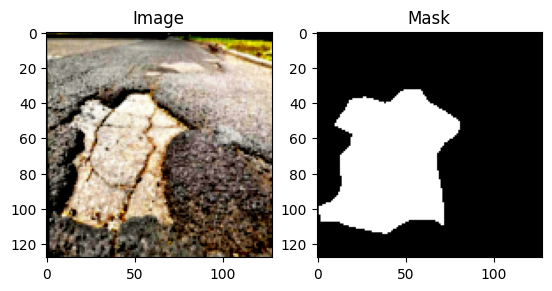

In [75]:
from matplotlib import pyplot as plt  

img, mask = train_dataset[66]
img_disp = img.permute(1, 2, 0).numpy()
mask_disp = mask.squeeze(0).numpy()

plt.subplot(1, 2, 1)
plt.imshow(img_disp)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_disp, cmap='gray')
plt.title("Mask")

In [76]:
print(len(train_dataset))
len(val_dataset)

720


60

### Train the model

In [77]:
model = u_net()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [78]:
from tqdm import tqdm # cool library

def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    
    for images, masks in tqdm(dataloader):

        outputs = model(images)
        
        # If model outputs 2 channels, reduce to 1
        if outputs.shape[1] == 2:
            outputs = outputs[:, 1:2, :, :]  # Take channel 1 (positive class)

        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [79]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            outputs = model(images)
            if outputs.shape[1] == 2:
                outputs = outputs[:, 1:2, :, :]

            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


Ok now let;s train the U net

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:34<12:34, 34.29s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:09<12:06, 34.59s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:43<11:25, 34.29s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:17<10:51, 34.29s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:50<10:08, 33.81s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:22<09:28, 33.44s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:56<08:55, 33.47s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:30<08:26, 33.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [05:05<07:56, 34.01s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [06:26<10:29, 48.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [07:39<11:11, 55.92s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [09:10<12:14, 66.74s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [10:42<12:22, 74.27s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [12:14<11:56, 79.60s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [13:37<10:45, 80.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [15:11<09:53, 84.82s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [16:45<08:45, 87.52s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [18:18<07:26, 89.23s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [19:55<06:05, 91.49s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [21:05<04:15, 85.20s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [21:43<02:22, 71.04s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [22:21<01:00, 60.98s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:13<00:13, 13.08s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:25<00:00, 12.66s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.6284 | Val Loss: 0.6224

Epoch 2/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:35<13:08, 35.82s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:10<12:23, 35.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:41<10:59, 33.00s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:11<10:07, 32.00s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:41<09:25, 31.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:12<08:46, 30.97s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:42<08:10, 30.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:12<07:38, 30.56s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:42<07:05, 30.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:14<06:39, 30.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:44<06:08, 30.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:14<05:36, 30.59s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:44<05:04, 30.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:15<04:32, 30.32s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:44<04:01, 30.20s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:14<03:30, 30.12s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:44<03:00, 30.06s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:16<02:33, 30.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:11<02:30, 37.74s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [11:48<02:47, 55.73s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [13:27<02:17, 68.64s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [15:07<01:17, 77.95s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 50%|█████     | 1/2 [00:33<00:33, 33.27s/it]

torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [01:01<00:00, 30.67s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.5010 | Val Loss: 0.5404

Epoch 3/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [01:39<36:23, 99.25s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [03:16<34:19, 98.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [04:53<32:35, 97.75s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [06:32<31:04, 98.15s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [08:08<29:14, 97.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [09:46<27:35, 97.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [11:22<25:52, 97.00s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [12:59<24:16, 97.08s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [14:36<22:36, 96.90s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [16:15<21:11, 97.79s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [17:56<19:44, 98.72s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [19:35<18:05, 98.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [21:07<16:07, 96.78s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [22:42<14:24, 96.08s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [24:16<12:44, 95.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [25:52<11:08, 95.56s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [27:26<09:32, 95.36s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [28:34<07:14, 86.93s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [29:06<04:42, 70.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [29:39<02:57, 59.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [30:11<01:42, 51.11s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [30:45<00:45, 45.89s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:11<00:11, 11.24s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:21<00:00, 10.53s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.4321 | Val Loss: 0.4432

Epoch 4/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:32<11:49, 32.27s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:05<11:24, 32.60s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:38<11:01, 33.09s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:11<10:25, 32.91s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:45<09:59, 33.32s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:19<09:33, 33.71s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:53<08:59, 33.72s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:26<08:21, 33.44s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:58<07:43, 33.08s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:34<07:20, 33.86s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [06:06<06:40, 33.41s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:38<06:01, 32.86s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [07:09<05:23, 32.33s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:41<04:49, 32.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [08:13<04:16, 32.08s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:45<03:44, 32.11s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:16<03:11, 31.91s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:49<02:40, 32.10s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:21<02:08, 32.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:54<01:36, 32.27s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:26<01:04, 32.22s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:58<00:32, 32.32s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:11<00:11, 11.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:21<00:00, 10.56s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.3905 | Val Loss: 0.4015

Epoch 5/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:31<11:40, 31.84s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:03<11:09, 31.86s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:35<10:32, 31.61s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:07<10:03, 31.78s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:39<09:34, 31.91s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:11<09:03, 31.95s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:42<08:28, 31.80s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:15<08:00, 32.01s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:48<07:33, 32.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:22<07:08, 32.94s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:53<06:29, 32.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:24<05:51, 31.95s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:55<05:16, 31.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:26<04:42, 31.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:57<04:10, 31.30s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:29<03:39, 31.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:00<03:08, 31.34s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:31<02:36, 31.27s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:02<02:05, 31.32s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:34<01:33, 31.28s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:05<01:02, 31.26s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:36<00:31, 31.36s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.03s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.3601 | Val Loss: 0.3754

Epoch 6/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:18, 30.85s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:02<10:58, 31.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:33<10:24, 31.23s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:04<09:50, 31.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:35<09:18, 31.01s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:06<08:47, 31.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:37<08:15, 30.99s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:08<07:46, 31.11s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:40<07:17, 31.22s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:11<06:44, 31.13s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:42<06:12, 31.07s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:12<05:41, 31.03s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:43<05:09, 30.97s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:14<04:38, 30.93s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:45<04:07, 30.98s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:16<03:37, 31.06s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:48<03:06, 31.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:19<02:35, 31.03s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:49<02:03, 30.98s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:20<01:32, 30.95s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:51<01:02, 31.01s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:22<00:30, 30.96s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.61s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.12s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.3343 | Val Loss: 0.3529

Epoch 7/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:14, 30.66s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:01<10:46, 30.77s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:32<10:18, 30.95s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:03<09:47, 30.93s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:34<09:18, 31.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:05<08:47, 31.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:37<08:17, 31.11s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:07<07:43, 30.92s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:38<07:13, 30.96s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:09<06:41, 30.90s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:40<06:10, 30.86s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:10<05:39, 30.82s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:41<05:08, 30.83s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:12<04:37, 30.80s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:43<04:06, 30.83s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:14<03:37, 31.01s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:45<03:05, 30.92s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:16<02:34, 30.91s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:47<02:03, 30.96s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:18<01:33, 31.03s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:49<01:01, 30.97s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:20<00:30, 30.95s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.12s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.3247 | Val Loss: 0.3376

Epoch 8/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:31<11:33, 31.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:03<11:07, 31.80s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:34<10:30, 31.51s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:06<09:59, 31.57s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:37<09:27, 31.54s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:08<08:51, 31.28s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:39<08:18, 31.14s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:10<07:46, 31.13s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:41<07:15, 31.09s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:13<06:46, 31.25s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:44<06:15, 31.31s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:15<05:43, 31.26s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:46<05:11, 31.16s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:18<04:40, 31.21s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:49<04:09, 31.19s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:20<03:38, 31.28s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:52<03:08, 31.33s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:23<02:37, 31.44s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:55<02:06, 31.61s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:27<01:34, 31.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:00<01:03, 31.92s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:31<00:31, 31.78s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.66s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.30s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.3049 | Val Loss: 0.3172

Epoch 9/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:13, 30.60s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:01<10:47, 30.83s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:32<10:21, 31.06s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:04<09:52, 31.17s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:35<09:21, 31.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:06<08:50, 31.21s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:38<08:20, 31.28s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:09<07:49, 31.32s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:40<07:16, 31.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:14<06:57, 32.15s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:49<06:37, 33.09s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:23<06:06, 33.35s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:57<05:34, 33.40s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:30<04:59, 33.31s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [08:02<04:24, 33.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:37<03:53, 33.34s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:11<03:22, 33.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:48<02:53, 34.66s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:23<02:19, 34.80s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:59<01:45, 35.07s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:33<01:09, 34.81s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [12:06<00:34, 34.28s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:12<00:12, 12.35s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:23<00:00, 11.51s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2874 | Val Loss: 0.3238

Epoch 10/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:35<13:05, 35.73s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:09<12:06, 34.61s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:43<11:24, 34.22s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:17<10:49, 34.19s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:50<10:07, 33.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:24<09:34, 33.82s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:57<08:56, 33.55s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:31<08:23, 33.60s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [05:04<07:51, 33.65s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:38<07:18, 33.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [06:12<06:46, 33.86s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:47<06:14, 34.04s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [07:21<05:40, 34.09s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:55<05:05, 33.95s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [08:30<04:33, 34.20s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [09:03<03:57, 33.90s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:35<03:19, 33.30s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [10:07<02:45, 33.06s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:40<02:12, 33.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [11:12<01:37, 32.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:45<01:05, 32.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [12:17<00:32, 32.67s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:11<00:11, 11.01s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.41s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2676 | Val Loss: 0.3020

Epoch 11/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:31<11:30, 31.40s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:03<11:09, 31.88s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:35<10:40, 32.04s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:07<10:09, 32.07s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:39<09:35, 31.95s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:11<09:04, 32.05s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:45<08:38, 32.41s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:16<08:02, 32.19s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:47<07:25, 31.84s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:21<07:01, 32.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:54<06:30, 32.50s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:26<05:55, 32.29s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:58<05:21, 32.17s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:30<04:50, 32.27s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [08:03<04:18, 32.33s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:36<03:48, 32.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:08<03:14, 32.48s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:41<02:43, 32.65s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:13<02:09, 32.36s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:46<01:38, 32.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:19<01:05, 32.85s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:52<00:32, 32.70s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.94s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.32s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2587 | Val Loss: 0.3179

Epoch 12/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:31<11:40, 31.85s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:05<11:27, 32.74s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:36<10:44, 32.21s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:08<10:07, 31.96s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:40<09:38, 32.15s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:13<09:06, 32.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:45<08:35, 32.23s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:18<08:05, 32.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:50<07:35, 32.50s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:22<06:58, 32.19s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:55<06:29, 32.49s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:28<06:00, 32.74s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [07:01<05:26, 32.61s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:34<04:54, 32.71s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [08:06<04:20, 32.58s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:38<03:46, 32.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:10<03:13, 32.18s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:41<02:39, 31.93s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:12<02:07, 31.79s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:45<01:36, 32.13s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [11:20<01:05, 32.97s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:52<00:32, 32.62s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:19<00:00,  9.96s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2443 | Val Loss: 0.3026

Epoch 13/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:08, 30.40s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:00<10:39, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:31<10:10, 30.50s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:02<09:41, 30.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:32<09:11, 30.64s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:03<08:40, 30.61s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:34<08:10, 30.64s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:04<07:39, 30.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:34<07:06, 30.49s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:05<06:35, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:35<06:05, 30.47s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:06<05:35, 30.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:36<05:04, 30.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:07<04:34, 30.47s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:37<04:03, 30.48s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:08<03:33, 30.49s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:38<03:02, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:08<02:31, 30.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:39<02:01, 30.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:09<01:31, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:40<01:00, 30.42s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:10<00:30, 30.48s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.65s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:19<00:00, 10.00s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2333 | Val Loss: 0.2784

Epoch 14/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:09, 30.42s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:00<10:38, 30.40s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:31<10:08, 30.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:02<09:43, 30.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:32<09:11, 30.65s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:03<08:41, 30.67s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:34<08:11, 30.70s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:05<07:42, 30.81s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:36<07:11, 30.79s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:06<06:39, 30.70s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:37<06:07, 30.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:07<05:36, 30.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:37<05:04, 30.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:08<04:33, 30.44s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:38<04:03, 30.41s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:09<03:33, 30.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:39<03:02, 30.42s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:09<02:31, 30.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:40<02:01, 30.40s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:10<01:31, 30.49s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:41<01:00, 30.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:12<00:30, 30.55s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.47s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.09s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2241 | Val Loss: 0.3020

Epoch 15/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:09, 30.42s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:00<10:37, 30.34s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:31<10:06, 30.33s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:01<09:41, 30.58s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:32<09:12, 30.67s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:03<08:44, 30.83s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:34<08:14, 30.89s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:05<07:41, 30.77s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:36<07:10, 30.72s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:07<06:41, 30.85s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:37<06:09, 30.77s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:08<05:37, 30.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:38<05:05, 30.54s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:08<04:34, 30.47s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:38<04:02, 30.34s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:09<03:32, 30.29s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:39<03:02, 30.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:10<02:32, 30.50s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:41<02:02, 30.55s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:11<01:31, 30.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:42<01:01, 30.57s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:13<00:30, 30.65s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.74s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:20<00:00, 10.00s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2141 | Val Loss: 0.2912

Epoch 16/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:08, 30.37s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:01<10:41, 30.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:31<10:08, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:02<09:42, 30.64s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:32<09:08, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:02<08:36, 30.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:33<08:08, 30.55s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:04<07:39, 30.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:35<07:09, 30.64s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:06<06:39, 30.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:36<06:09, 30.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:07<05:38, 30.73s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:38<05:06, 30.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:08<04:36, 30.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:39<04:05, 30.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:09<03:34, 30.58s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:40<03:03, 30.52s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:10<02:33, 30.60s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:41<02:02, 30.71s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:13<01:32, 30.86s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:43<01:01, 30.81s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:14<00:30, 30.80s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:19<00:00,  9.92s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.2000 | Val Loss: 0.2924

Epoch 17/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:11, 30.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:01<10:44, 30.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:32<10:13, 30.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:02<09:41, 30.63s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:33<09:10, 30.60s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:03<08:41, 30.67s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:34<08:10, 30.69s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:05<07:41, 30.76s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:35<07:08, 30.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:06<06:36, 30.53s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:36<06:04, 30.35s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:06<05:34, 30.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:37<05:04, 30.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:07<04:34, 30.54s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [07:38<04:04, 30.59s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:10<03:35, 30.84s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [08:40<03:04, 30.72s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:11<02:33, 30.75s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [09:41<02:02, 30.62s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:12<01:32, 30.78s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [10:43<01:01, 30.72s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [11:13<00:30, 30.67s/it]

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])


 50%|█████     | 1/2 [00:10<00:10, 10.52s/it]

torch.Size([32, 64, 128, 128])
torch.Size([28, 64, 128, 128])
torch.Size([28, 128, 64, 64])
torch.Size([28, 256, 32, 32])
torch.Size([28, 512, 16, 16])
torch.Size([28, 1024, 8, 8])
torch.Size([28, 512, 16, 16])
torch.Size([28, 256, 32, 32])
torch.Size([28, 128, 64, 64])


100%|██████████| 2/2 [00:19<00:00,  9.89s/it]


torch.Size([28, 64, 128, 128])
Train Loss: 0.1882 | Val Loss: 0.2910

Epoch 18/20


  0%|          | 0/23 [00:00<?, ?it/s]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  4%|▍         | 1/23 [00:30<11:17, 30.79s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


  9%|▊         | 2/23 [01:02<11:02, 31.54s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 13%|█▎        | 3/23 [01:34<10:34, 31.71s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 17%|█▋        | 4/23 [02:06<10:03, 31.79s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 22%|██▏       | 5/23 [02:38<09:34, 31.90s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 26%|██▌       | 6/23 [03:11<09:06, 32.13s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 30%|███       | 7/23 [03:44<08:39, 32.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 35%|███▍      | 8/23 [04:16<08:06, 32.46s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 39%|███▉      | 9/23 [04:49<07:35, 32.57s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 43%|████▎     | 10/23 [05:23<07:09, 33.00s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 48%|████▊     | 11/23 [05:55<06:32, 32.68s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 52%|█████▏    | 12/23 [06:27<05:58, 32.55s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 57%|█████▋    | 13/23 [06:59<05:22, 32.26s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 61%|██████    | 14/23 [07:32<04:51, 32.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 65%|██████▌   | 15/23 [08:04<04:19, 32.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 70%|██████▉   | 16/23 [08:37<03:47, 32.45s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 74%|███████▍  | 17/23 [09:09<03:13, 32.33s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 78%|███████▊  | 18/23 [09:41<02:41, 32.39s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 83%|████████▎ | 19/23 [10:13<02:08, 32.11s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 87%|████████▋ | 20/23 [10:39<01:31, 30.43s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 91%|█████████▏| 21/23 [2:11:55<1:13:30, 2205.13s/it]

torch.Size([32, 64, 128, 128])
torch.Size([32, 128, 64, 64])
torch.Size([32, 256, 32, 32])
torch.Size([32, 512, 16, 16])
torch.Size([32, 1024, 8, 8])
torch.Size([32, 512, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 128, 64, 64])
torch.Size([32, 64, 128, 128])


 96%|█████████▌| 22/23 [2:12:20<25:50, 1550.98s/it]  

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 512, 16, 16])
torch.Size([16, 256, 32, 32])
torch.Size([16, 128, 64, 64])
torch.Size([16, 64, 128, 128])


### Now let's see some output of the model

In [ ]:
import random
from matplotlib import pyplot as plt

model.eval()
fig = plt.figure(figsize=(10, 7))
n = 3
for i in range(n):
    idx = random.randint(0, len(val_dataset)-1)
    img, mask = val_dataset[idx] # img: [C, H, W]

    input_tensor = img.unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
        output = output.squeeze().cpu().numpy()

    # Convert image to [H, W, C] for display 😼
    img_disp = img.permute(1, 2, 0).numpy()
    mask_disp = mask.squeeze(0).numpy()

    plt.subplot(n, 3, 3*i+1)
    plt.imshow(img_disp)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(n, 3, 3*i+2)
    plt.imshow(mask_disp)
    plt.title("Input Mask")
    plt.axis('off')

    plt.subplot(n, 3, 3*i+3)
    if output.ndim == 3:
        output = output[1] if output.shape[0] == 2 else output[0]  # binary seg
    plt.imshow(output, cmap='gray')
    plt.title("Output of the Model")
    plt.axis('off')

plt.show()

### Save the model just in case 

In [ ]:
torch.save(model.state_dict(), "unet_weights.pth")

+load if needed

In [ ]:
model = u_net()  # Or your model class
model.load_state_dict(torch.load("unet_weights.pth"))
model.eval() 